<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning project: kNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

import pathlib
import random
from statistics import mode, StatisticsError
import timeit

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Download the images

In [13]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz

data_root_orig = tf.keras.utils.get_file('new_pic',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/new_pic/Guillaume_Loranchet
/root/.keras/datasets/new_pic/.DS_Store
/root/.keras/datasets/new_pic/Guillaume_Paya


In [14]:
data_root_orig_1 = tf.keras.utils.get_file('new_pic(1)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(1).tar.gz',
                                         untar=True)
data_root_1 = pathlib.Path(data_root_orig_1)
for item in data_root_1.iterdir():
  print(item)

/root/.keras/datasets/new_pic(1)/.DS_Store
/root/.keras/datasets/new_pic(1)/Miha_S


In [15]:
data_root_orig_2 = tf.keras.utils.get_file('new_pic(2)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(2).tar.gz',
                                         untar=True)
data_root_2 = pathlib.Path(data_root_orig_2)
for item in data_root_2.iterdir():
  print(item)

/root/.keras/datasets/new_pic(2)/.DS_Store
/root/.keras/datasets/new_pic(2)/Nicholas_S


In [16]:
data_root_orig_test = tf.keras.utils.get_file('next_ite',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/result.tar.gz',
                                         untar=True)
data_root_test = pathlib.Path(data_root_orig_test)
for item in data_root_test.iterdir():
  print(item)

/root/.keras/datasets/next_ite/Guillaume_Loranchet
/root/.keras/datasets/next_ite/.DS_Store
/root/.keras/datasets/next_ite/Guillaume_Paya
/root/.keras/datasets/next_ite/Nicholas_S
/root/.keras/datasets/next_ite/Miha_S


##Inspect the dataset

In [0]:
all_image_paths_0 = list(data_root.glob('*/*'))
all_image_paths_1 = list(data_root_1.glob('*/*'))
all_image_paths_2 = list(data_root_2.glob('*/*'))

all_image_paths_train = all_image_paths_2 + all_image_paths_1 + all_image_paths_0

all_image_paths_train = [str(path) for path in all_image_paths_train]
random.shuffle(all_image_paths_train)

all_image_paths_test = list(data_root_test.glob('*/*'))

all_image_paths_test = [str(path) for path in all_image_paths_test]
random.shuffle(all_image_paths_test)

image_count_train = len(all_image_paths_train)

In [18]:
all_image_paths_train[:5]

['/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_17_sp_3_rot_anty_2.png',
 '/root/.keras/datasets/new_pic(2)/Nicholas_S/Nicholas_48_rot_anty_1.png',
 '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_51_sharpened_1_6_rot_anty_0.png',
 '/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_10_blurred_1_rot_anty_0.png',
 '/root/.keras/datasets/new_pic/Guillaume_Paya/Guillaume_Paya_42_sp_5_rot_anty_5.png']

In [19]:
all_image_paths_test[:5]

['/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_149.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_S_155.png',
 '/root/.keras/datasets/next_ite/Miha_S/Miha_S_117.png',
 '/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_156.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_S_151.png']

###Show images

Training images


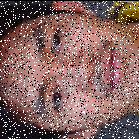

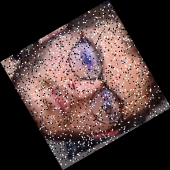


Testing images


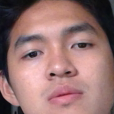

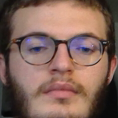

In [20]:
import IPython.display as display

print('Training images')
for n in range(2):
  image_path = random.choice(all_image_paths_train)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

print('\nTesting images')
for n in range(2):
  image_path = random.choice(all_image_paths_test)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [21]:
label_names_0 = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names_1 = sorted(item.name for item in data_root_1.glob('*/') if item.is_dir())
label_names_2 = sorted(item.name for item in data_root_2.glob('*/') if item.is_dir())

label_names = label_names_0 + label_names_1 + label_names_2
label_names

['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']

In [22]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Guillaume_Paya': 1, 'Miha_S': 2, 'Nicholas_S': 3}

In [0]:
for name in label_names:
  stri = '/root/.keras/datasets/next_ite/' + name + '/.DS_Store'
  if stri in all_image_paths_test:
    all_image_paths_test.remove(stri)
  stri = '/root/.keras/datasets/next_ite/' + name + '/._.DS_Store'
  if stri in all_image_paths_test:
    all_image_paths_test.remove(stri)

In [24]:
all_image_labels_train = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_train]

print("First 10 labels indices of training set: ", all_image_labels_train[:10])

all_image_labels_test = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths_test]

print("First 10 labels indices of training set: ", all_image_labels_test[:10])

First 10 labels indices of training set:  [0, 3, 0, 0, 1, 1, 2, 3, 0, 2]
First 10 labels indices of training set:  [1, 3, 2, 1, 3, 3, 1, 1, 3, 3]


###Load images with Tensor Flow

In [25]:
img_path = all_image_paths_train[0]
img_path

'/root/.keras/datasets/new_pic/Guillaume_Loranchet/Guillaume_Loranchet_17_sp_3_rot_anty_2.png'

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

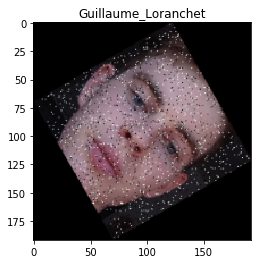

In [27]:
image_path = all_image_paths_train[0]
label = all_image_labels_train[0]

plt.imshow(load_and_preprocess_image(image_path)/255)
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [28]:
n_train = len(all_image_paths_train)

x_train_aux = [load_and_preprocess_image(all_image_paths_train[i]) for i in range(n_train)]
x_train_aux_2 = np.array([np.array(x_train_aux[i]) for i in range(n_train)])
x_train = x_train_aux_2 / 255   #normalize between 0 and 1

n_test = len(all_image_paths_test)

x_test_aux = [load_and_preprocess_image(all_image_paths_test[i]) for i in range(n_test)]
x_test_aux_2 = np.array([np.array(x_test_aux[i]) for i in range(n_test)])
x_test = x_test_aux_2 / 255   #normalize between 0 and 1
print(x_train.shape)
print(x_test.shape)

y_train = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_train])
y_test = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels_test])
print(y_train.shape)
print(y_test.shape)

labels = label_names
print(labels)

print(y_train[0])

(4140, 192, 192, 3)
(177, 192, 192, 3)
(4140, 4)
(177, 4)
['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']
[1 0 0 0]


(4140, 4)


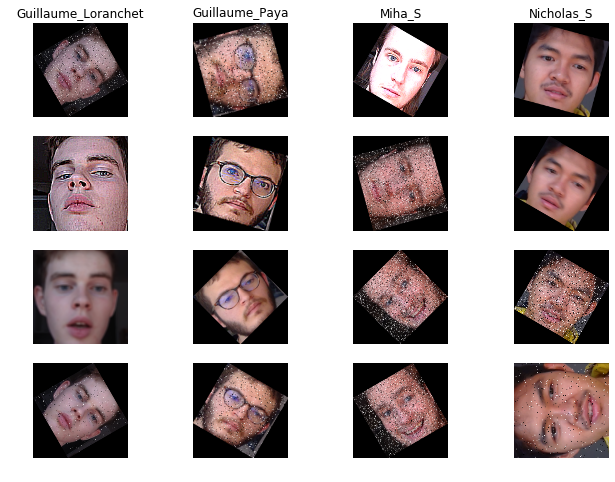

(177, 4)


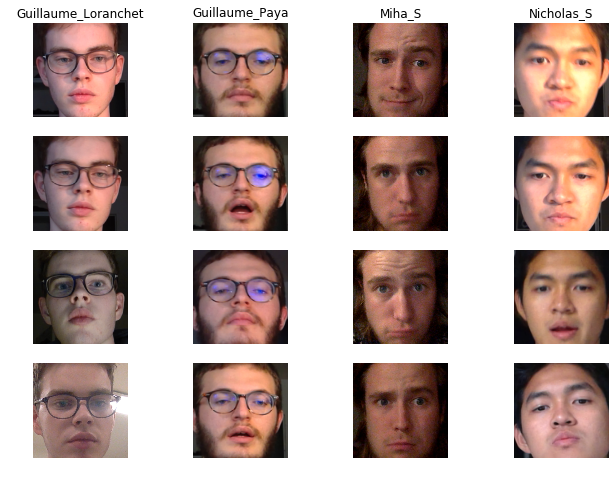

In [29]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, len(categories[0]), figsize=(11,8))
    print(categories.shape)
    for i in range(len(categories[0])):
        count = 0
        j = 0
        while count < n and j < len(categories):
            #print(j,i)
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(4, x_train, y_train, labels)
show_first_n_images_in_categories(4, x_test, y_test, labels)

##kNN Model

In [30]:
def euclidean_distance(ima_1,ima_2):
  return np.sqrt(sum(sum(sum((ima_1-ima_2)**2))))

print(euclidean_distance(x_train[0],x_train[1]))

71.3294863985632


In [31]:
def test(ima_test,label):
  print(label)
  x1, x2, x3, x4 = [],[],[],[]
  for i in range(0,100):
    if y_train[i][0]:
      x1.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][1]:
      x2.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][2]:
      x3.append(euclidean_distance(ima_test,x_train[i]))
    elif y_train[i][3]:
      x4.append(euclidean_distance(ima_test,x_train[i]))

  liste = [np.mean(x1),np.mean(x2),np.mean(x3),np.mean(x4)]
  return liste

test(x_test[32],y_test[32])

[0 1 0 0]


[99.32312409038111, 110.54310356647089, 105.6959576991656, 101.70312060761563]

In [0]:
def average(liste):
  return sum(liste)/len(liste)

In [0]:
def clustering(x,y,k):
  nb_pers = len(y[0])  #4
  res = [[] for _ in range(nb_pers)]
  intermediate = [[] for _ in range(nb_pers)]
  
  for i in range(len(x)):
    for j in range(nb_pers):
      if len(intermediate[j]) == k:   #make groups of size k
        res[j].append(average(intermediate[j]))  
        intermediate[j] = []
    for j in range(nb_pers):
      if y[i][j]:   # i-th picture represent the j-th person in labels
        intermediate[j].append(x[i])
  for j in range(nb_pers):
    if len(intermediate[j]) != 0:
      res[j].append(average(intermediate[j])) 
  return res
        

A = clustering(x_train,y_train,100)

In [34]:
def try_mode(liste):
  '''check if there are more than 1 mode'''
  try:
    return mode(liste)
  except StatisticsError:
    return -1
  
B = [1,2,3]
try_mode(B)

-1

In [0]:
A = clustering(x_train,y_train,5)

def kNN(ima_input,A,k):  
  res_aux = {}
  for i in range(len(A)):
    for j in range(len(A[i])):
      res_aux[euclidean_distance(ima_input,A[i][j])] = i
        
  res = [value for (key,value) in sorted(res_aux.items())]   #take only the first k closest element
  #print(res)
  while try_mode(res[:k]) == -1:  #return the most frequent element
    k += 1
  return mode(res[:k])
  
  
def test_knn(A,k):
  res = 0
  for i in range(len(y_test)):
    val = kNN(x_test[i],A,k)
    if y_test[i][val]:
      res += 1
  return res/len(y_test)  

In [39]:
n = len(y_test)

def test_final():
  for i in [1,2,3,4,5,6,7,8,10,12,15]:
    A = clustering(x_train,y_train,i)
    def test_time():
      print('Cluster of {} elements'.format(i))
      print('Accuracy: ',test_knn(A,5))

    print('Time to predict each picture',timeit.timeit(test_time,number=1)/n,'\n')
    
test_final()

Cluster of 1 elements
Accuracy:  0.4519774011299435
Time to predict each picture 5.509470149999999 

Cluster of 2 elements
Accuracy:  0.5649717514124294
Time to predict each picture 0.9767672461638421 

Cluster of 3 elements
Accuracy:  0.5423728813559322
Time to predict each picture 1.3214222332033896 

Cluster of 4 elements
Accuracy:  0.6949152542372882
Time to predict each picture 0.4847251269265539 

Cluster of 5 elements
Accuracy:  0.632768361581921
Time to predict each picture 0.43708202742372726 

Cluster of 6 elements
Accuracy:  0.6440677966101694
Time to predict each picture 0.32536828557627134 

Cluster of 7 elements
Accuracy:  0.6214689265536724
Time to predict each picture 0.3646449667118636 

Cluster of 8 elements
Accuracy:  0.5706214689265536
Time to predict each picture 0.2441796150169492 

Cluster of 10 elements
Accuracy:  0.6610169491525424
Time to predict each picture 0.1939253001242925 

Cluster of 12 elements
Accuracy:  0.480225988700565
Time to predict each picture 

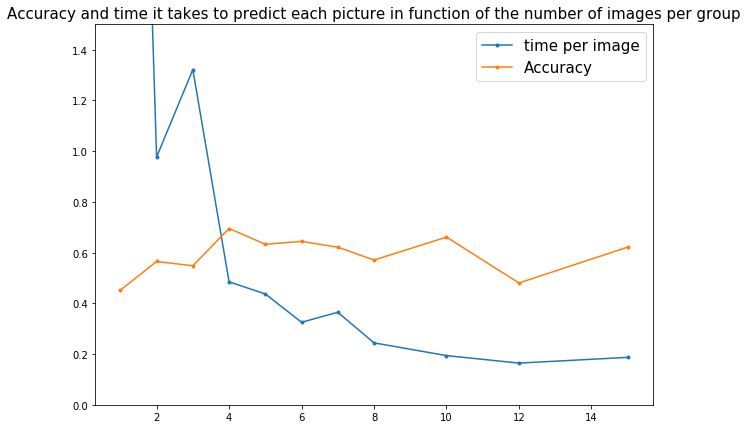

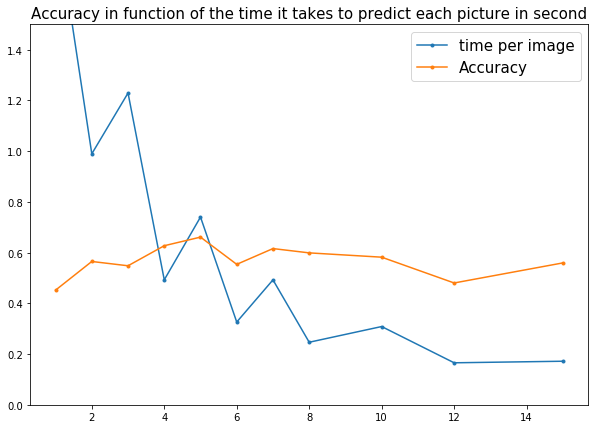

"\nA = [1.621962771571754,0.822498746020502,0.7807300900546698,0.4145117971435072,0.7066861600022774 ,0.2750192653462417,0.3777576999931675,0.23307825262870246]\nB = [0.8815489749430524,0.8952164009111617,0.8747152619589977,0.9043280182232346,0.8747152619589977,0.8701594533029613,0.8724373576309795,0.8633257403189066]\nC = [i for i in range(1,9)]\n\nplt.figure(figsize=(10,7))\n#plt.plot(A[0],B[0])\nplt.plot(C,A,marker='.')\nplt.plot(C,B,marker='.')\nplt.title('Accuracy in function of the time it takes to predict each picture in second',fontsize=15)\nplt.legend(('time per image','Accuracy'),loc='best',fontsize=15)\nplt.show()\n\nA = [1.553445454671982 ,0.792043179412301 ,1.6340474191617311 ,0.39476990576082016,0.5778299328633254 ,0.26462585976537567 ,0.355893313321184,0.20078500869020463,0.2482689212346235,0.13494598851936224,0.1768164523052389 ]\nB = [0.8815489749430524,0.89749430523918,0.8587699316628702,0.8701594533029613,0.8838268792710706,0.8246013667425968,0.8451025056947609,0.671

In [44]:
A = [5.509470149999999,0.9767672461638421 ,1.3214222332033896 ,0.4847251269265539 ,0.43708202742372726 ,0.32536828557627134 ,0.3646449667118636 ,0.2441796150169492 ,0.1939253001242925 ,0.1643949571977422 ,0.18692199483615757 ]
B = [0.4519774011299435,0.5649717514124294,0.5480225988700564,0.6949152542372882,0.632768361581921,0.6440677966101694,0.6214689265536724,0.5706214689265536,0.6610169491525424,0.480225988700565,0.6214689265536724]
C = [i for i in range(1,9)]+[10,12,15]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy and time it takes to predict each picture in function of the number of images per group, check the first k = 5 images',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.ylim([0,1.5])
plt.show()

A = [1.9345539544124293,0.9893024473559323,1.2290385608757062,0.4926231926723159 ,0.7401058078813552,0.326265965728814,0.49248329315819217,0.24658806461581925,0.30851309332768395,0.16557568342372855,0.17173665325988668]
B = [0.4519774011299435,0.5649717514124294,0.5480225988700564,0.6271186440677966,0.6610169491525424,0.5536723163841808,0.615819209039548,0.5988700564971752,0.5819209039548022,0.480225988700565,0.559322033898305]
C = [i for i in range(1,9)]+[10,12,15]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy and time it takes to predict each picture in function of the number of images per group, check the first k = 2 images',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.ylim([0,1.5])
plt.show()


'''
A = [1.621962771571754,0.822498746020502,0.7807300900546698,0.4145117971435072,0.7066861600022774 ,0.2750192653462417,0.3777576999931675,0.23307825262870246]
B = [0.8815489749430524,0.8952164009111617,0.8747152619589977,0.9043280182232346,0.8747152619589977,0.8701594533029613,0.8724373576309795,0.8633257403189066]
C = [i for i in range(1,9)]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy in function of the time it takes to predict each picture in second',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.show()

A = [1.553445454671982 ,0.792043179412301 ,1.6340474191617311 ,0.39476990576082016,0.5778299328633254 ,0.26462585976537567 ,0.355893313321184,0.20078500869020463,0.2482689212346235,0.13494598851936224,0.1768164523052389 ]
B = [0.8815489749430524,0.89749430523918,0.8587699316628702,0.8701594533029613,0.8838268792710706,0.8246013667425968,0.8451025056947609,0.6719817767653758,0.662870159453303,0.7562642369020501,0.662870159453303]
C = [i for i in range(1,9)]+[10,12,15]

plt.figure(figsize=(10,7))
#plt.plot(A[0],B[0])
plt.plot(C,A,marker='.')
plt.plot(C,B,marker='.')
plt.title('Accuracy in function of the time it takes to predict each picture in second',fontsize=15)
plt.legend(('time per image','Accuracy'),loc='best',fontsize=15)
plt.show()
'''